In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import time

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
 #Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.


In [4]:
# Data Paths
train_dir = '/kaggle/input/ucm-data/Images/train'
val_dir = '/kaggle/input/ucm-data/Images/val'
test_dir = '/kaggle/input/ucm-data/Images/test'

# Image Parameters
IMG_SIZE = (600, 600)
BATCH_SIZE = 16

In [5]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=30,        # Augmentations to improve generalization
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Load and Resize Images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 1260 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


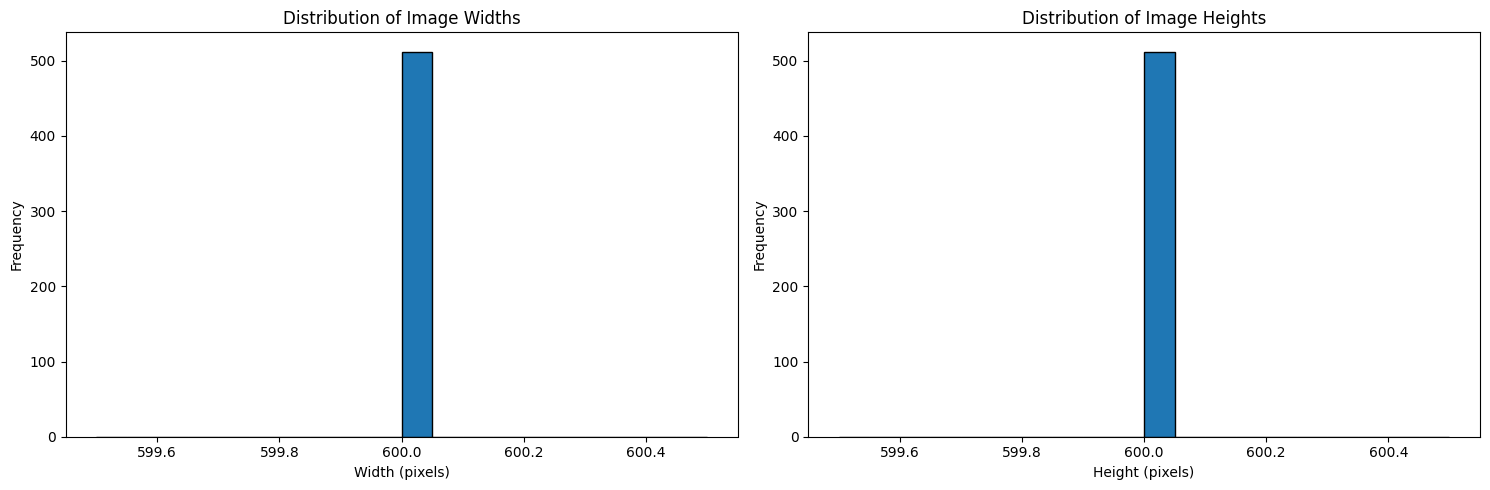

Width Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00

Height Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00


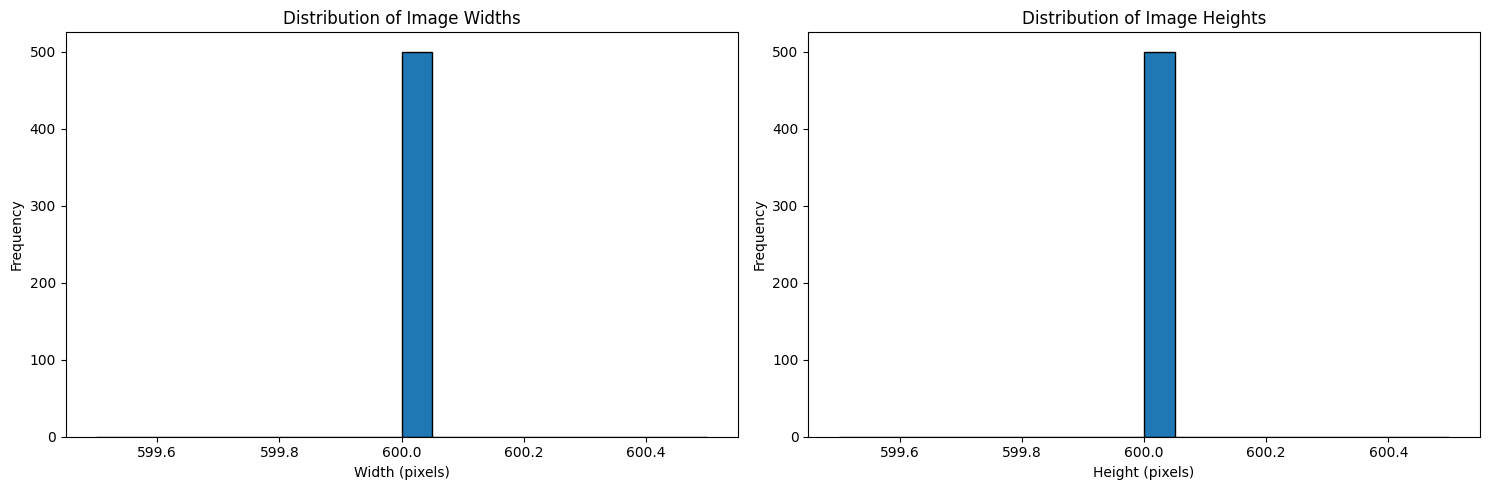

Width Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00

Height Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00


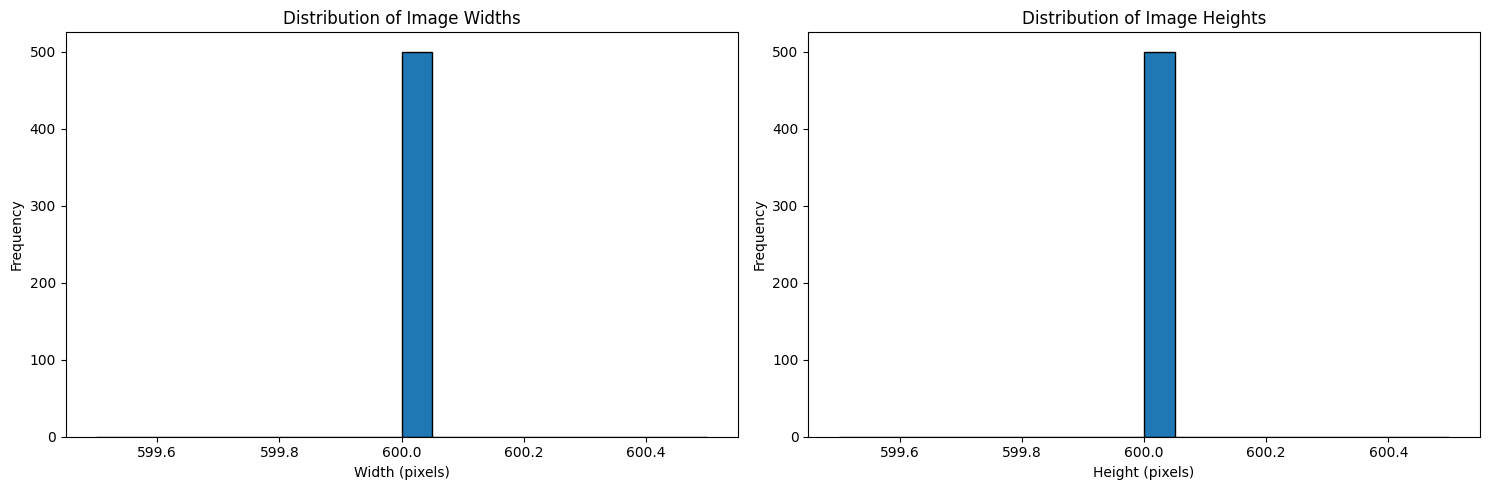

Width Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00

Height Statistics:
Mean: 600.00
Median: 600.00
Min: 600
Max: 600
Standard Deviation: 0.00


In [6]:
def verify_image_sizes(generator):
    """
    Verify and visualize image sizes in the dataset
    
    Parameters:
    -----------
    generator : tensorflow.keras.preprocessing.image.DirectoryIterator
        Image data generator
    
    Returns:
    --------
    tuple: (width statistics, height statistics)
    """
    # Collect image sizes
    widths = []
    heights = []
    
    # Iterate through batches
    for batch in generator:
        images = batch[0]
        
        # Collect sizes of images in this batch
        for img in images:
            widths.append(img.shape[1])
            heights.append(img.shape[0])
        
        # Stop after processing some batches to avoid long processing
        if len(widths) >= 500:  # Adjust this number as needed
            break
    
    # Create subplots
    plt.figure(figsize=(15, 5))
    
    # Width Histogram
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, edgecolor='black')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')
    
    # Height Histogram
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, edgecolor='black')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Width Statistics:")
    print(f"Mean: {np.mean(widths):.2f}")
    print(f"Median: {np.median(widths):.2f}")
    print(f"Min: {np.min(widths)}")
    print(f"Max: {np.max(widths)}")
    print(f"Standard Deviation: {np.std(widths):.2f}")
    
    print("\nHeight Statistics:")
    print(f"Mean: {np.mean(heights):.2f}")
    print(f"Median: {np.median(heights):.2f}")
    print(f"Min: {np.min(heights)}")
    print(f"Max: {np.max(heights)}")
    print(f"Standard Deviation: {np.std(heights):.2f}")

# Usage in main script
# Verify sizes for train, validation, and test generators
verify_image_sizes(train_generator)
verify_image_sizes(val_generator)
verify_image_sizes(test_generator)

In [7]:
def build_fine_tuned_model(num_classes):
    base_model = tf.keras.applications.EfficientNetB7(
        weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)
    )

    # Freeze all layers in EfficientNet except the last 3 fully connected layers
    for layer in base_model.layers[:-3]:  
        layer.trainable = False  # Keep feature extractor frozen
    
    # Ensure the last 3 layers are trainable
    for layer in base_model.layers[-3:]:  
        layer.trainable = True  

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    return model

# Number of classes
num_classes = len(train_generator.class_indices)

# Build and Compile Model
fine_tune_model = build_fine_tuned_model(num_classes)

fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for stability
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Print model summary and trainable parameters
fine_tune_model.summary()
total_params = np.sum([tf.keras.backend.count_params(w) for w in fine_tune_model.trainable_weights])
print(f"Total trainable parameters: {total_params}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 600, 600, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 600, 600, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 600, 600, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 600, 600, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 601, 601, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 300, 300, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 300, 300, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 300, 300, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 300, 300, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 300, 300, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 300, 300, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,758,700 (247.03 MB)

 Trainable params: 2,304,533 (8.79 MB)

 Non-trainable params: 62,454,167 (238.24 MB)

Total trainable parameters: 2304533


In [9]:
epoch_times = []
history_dict = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": [], "time_taken": []}

# Train the model while recording time for each epoch
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()

    history_fine = fine_tune_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,
        callbacks=[early_stopping, reduce_lr]
    )

    end_time = time.time()
    epoch_times.append(end_time - start_time)

    history_dict["loss"].append(history_fine.history["loss"][0])
    history_dict["accuracy"].append(history_fine.history["accuracy"][0])
    history_dict["val_loss"].append(history_fine.history["val_loss"][0])
    history_dict["val_accuracy"].append(history_fine.history["val_accuracy"][0])
    history_dict["time_taken"].append(epoch_times[-1])

    # Convert history to DataFrame and save
    history_df = pd.DataFrame(history_dict)
    history_df.to_csv("fine_tune_training_history.csv", index=False)

print("Fine-tuning history with time taken saved to fine_tune_training_history.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.0491 - loss: 3.0455 - val_accuracy: 0.1500 - val_loss: 2.9170 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.1635 - loss: 2.8828 - val_accuracy: 0.3071 - val_loss: 2.7700 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2409 - loss: 2.7471 - val_accuracy: 0.4357 - val_loss: 2.6203 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.3606 - loss: 2.5884 - val_accuracy: 0.5119 - val_loss: 2.4720 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.4644 - loss: 2.4395 - val_accuracy: 0.5714 - val_loss: 2.3338 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5639 - loss: 2.2914 - val_accuracy: 0.6190 - val_loss: 2.2017 - learning_rate: 1.0000e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5782 - loss: 2.1831 - val_accuracy: 0.6500 - val_loss: 2.0765 - learning_rate: 1.0

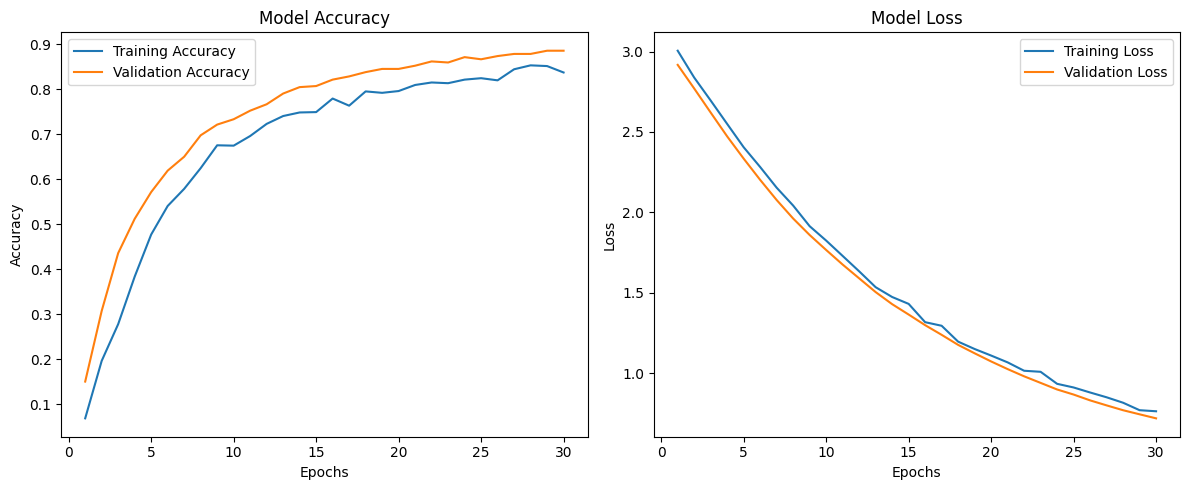

In [10]:
# Plot Training Accuracy & Loss Graphs
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict["accuracy"], label="Training Accuracy")
plt.plot(epochs_range, history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict["loss"], label="Training Loss")
plt.plot(epochs_range, history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.savefig("fine_tune_training_curves.png", dpi=300)
plt.show()

In [11]:
# Save the trained model
fine_tune_model.save("fine_tune_efficientnetb7_transfer_learning.h5")
print("model saved.")

model saved.
